<a href="https://colab.research.google.com/github/ZackPashkin/Lambda-network-on-Resnet-cifar-example-colab/blob/main/Lambda_Resnet_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install einops
!pip install torchtoolbox

     |████████████████████████████████| 61kB 4.1MB/s 


In [2]:
#author: PistonY https://gist.github.com/PistonY/ad33ab9e3d5f9a6a38345eb184e68cb4
#lambda layers implementation https://github.com/lucidrains/lambda-networks
import torch
import torch.nn.functional as F
from torch import nn, einsum
from einops import rearrange
from torchtoolbox.nn import Activation


# helpers functions

def exists(val):
    return val is not None


def default(val, d):
    return val if exists(val) else d


# lambda layer
def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class LambdaLayer(nn.Module):
    def __init__(self, dim, *, dim_k, n=None, r=None, heads=4, dim_out=None, dim_u=1):
        super().__init__()
        dim_out = default(dim_out, dim)
        self.u = dim_u  # intra-depth dimension
        self.heads = heads

        assert (dim_out % heads) == 0, 'values dimension must be divisible by number of heads for multi-head query'
        dim_v = dim_out // heads

        self.to_q = nn.Conv2d(dim, dim_k * heads, 1, bias=False)
        self.to_k = nn.Conv2d(dim, dim_k * dim_u, 1, bias=False)
        self.to_v = nn.Conv2d(dim, dim_v * dim_u, 1, bias=False)

        self.norm_q = nn.BatchNorm2d(dim_k * heads)
        self.norm_v = nn.BatchNorm2d(dim_v * dim_u)

        self.local_contexts = exists(r)
        if exists(r):
            assert (r % 2) == 1, 'Receptive kernel size should be odd'
            self.pos_conv = nn.Conv3d(dim_u, dim_k, (1, r, r), padding=(0, r // 2, r // 2))
        else:
            assert exists(n), 'You must specify the total sequence length (h x w)'
            self.pos_emb = nn.Parameter(torch.randn(n, n, dim_k, dim_u))

    def forward(self, x):
        b, c, hh, ww, u, h = *x.shape, self.u, self.heads

        q = self.to_q(x)
        k = self.to_k(x)
        v = self.to_v(x)

        q = self.norm_q(q)
        v = self.norm_v(v)

        q = rearrange(q, 'b (h k) hh ww -> b h k (hh ww)', h=h)
        k = rearrange(k, 'b (u k) hh ww -> b u k (hh ww)', u=u)
        v = rearrange(v, 'b (u v) hh ww -> b u v (hh ww)', u=u)

        k = k.softmax(dim=-1)

        λc = einsum('b u k m, b u v m -> b k v', k, v)
        Yc = einsum('b h k n, b k v -> b n h v', q, λc)

        if self.local_contexts:
            v = rearrange(v, 'b u v (hh ww) -> b u v hh ww', hh=hh, ww=ww)
            λp = self.pos_conv(v)
            Yp = einsum('b h k n, b k v n -> b n h v', q, λp.flatten(3))
        else:
            λp = einsum('n m k u, b u v m -> b n k v', self.pos_emb, v)
            Yp = einsum('b h k n, b n k v -> b n h v', q, λp)

        Y = Yc + Yp
        out = rearrange(Y, 'b (hh ww) h v -> b (h v) hh ww', hh=hh, ww=ww)
        return out.contiguous()


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()

        self.conv1 = conv1x1(inplanes, planes)
        self.bn1 = nn.BatchNorm2d(planes)

        self.conv2 = LambdaLayer(planes, dim_k=16, r=15, heads=4, dim_u=1)
        self.pool = nn.AvgPool2d(3, 2, 1) if stride != 1 else nn.Identity()

        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.act = nn.ReLU(inplace=True)
        self.downsample = nn.Identity() if downsample is None else downsample

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.act(out)

        out = self.conv2(out)
        out = self.pool(out)

        out = self.conv3(out)
        out = self.bn3(out)

        identity = self.downsample(x)

        out += identity
        out = self.act(out)

        return out


class LambdaResnet(nn.Module):
    def __init__(self, layers, num_classes=1000, small_input=False):
        super(LambdaResnet, self).__init__()
        self.inplanes = 64
        if small_input:
            self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=3, stride=1, padding=1,
                                   bias=False)
        else:
            self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                                   bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.act = nn.ReLU(inplace=True)
        if small_input:
            self.maxpool = nn.Identity()
        else:
            self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(64, layers[0])
        self.layer2 = self._make_layer(128, layers[1], stride=2)
        self.layer3 = self._make_layer(256, layers[2], stride=2)
        self.layer4 = self._make_layer(512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()

        self.fc = nn.Linear(512 * Bottleneck.expansion, num_classes)

    def _make_layer(self, planes, blocks, stride=1, ):

        downsample = None

        if stride != 1 or self.inplanes != planes * Bottleneck.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * Bottleneck.expansion, stride),
                nn.BatchNorm2d(planes * Bottleneck.expansion),
            )

        layers = []
        layers.append(Bottleneck(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * Bottleneck.expansion
        for _ in range(1, blocks):
            layers.append(Bottleneck(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc(x)

        return x


def LambdaResnet18(**kwargs):
    """Constructs a ResNet-18 model.
    """
    return LambdaResnet([2, 2, 2, 2], **kwargs)


def LambdaResnet34(**kwargs):
    """Constructs a ResNet-34 model.
    """
    return LambdaResnet([3, 4, 6, 3], **kwargs)


def LambdaResnet50(**kwargs):
    """Constructs a ResNet-50 model.
    """
    return LambdaResnet([3, 4, 6, 3], **kwargs)


def LambdaResnet101(**kwargs):
    """Constructs a ResNet-101 model.
    """
    return LambdaResnet([3, 4, 23, 3], **kwargs)


def LambdaResnet152(**kwargs):
    """Constructs a ResNet-152 model.
    """
    return LambdaResnet([3, 8, 36, 3], **kwargs)

In [42]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader 
import torch.optim as optim
from torchsummary import summary

# Shows a summary of the network
def network_summary(network):
    summary(network,(3,224,224))
    return None

# Calculates the labels correspondig to the network's output
def predict_labels(output):
    _, pred_labels = torch.max(output, dim = 1)
    return pred_labels

# Calculates the number of matches between the predicted labels and the true labels
def correct_predictions(output, labels):
    pred_labels = predict_labels(output)
    corr_pred = torch.sum(pred_labels == labels).item()
    return corr_pred


def print_training_progress(epoch, epochs, batch_num, total_batches, notebook = False):
    if notebook:
        print('Epoch: ' + str(epoch + 1) + '/' + str(epochs) + ', Batch: ' + str(batch_num + 1) + '/' + str(total_batches))
    else:
        print('Epoch: ' + str(epoch + 1) + '/' + str(epochs) + ', Batch: ' + str(batch_num + 1) + '/' + str(total_batches), end = '\r')
    return None

def print_performance(metrics):
    epoch = metrics['epoch']
    train_loss = metrics['train_loss']
    train_acc = metrics['train_acc']
    valid_loss = metrics['valid_loss']
    valid_acc = metrics['valid_acc']
    print('Epoch: ' + str(epoch + 1) + ' || Train loss = ' + str(round(train_loss,2)) + ', Train Acc = ' + str(round(train_acc,2)) + ', Valid Loss = ' + str(round(valid_loss,2)) + ', Valid Acc = ' + str(round(valid_acc,2)))
    return None

def evaluate(network, dataloader, loss_fn, device = None):
    
    # Sends the network to the device
    if device:
        network.to(device)
    
    # Sets the metrics to zero
    network.eval()
    loss_value = 0
    acc_value = 0
    total_images = 0
    # Loops over the dataset
    for data in dataloader:
        # Gets the data
        images, labels = data
        # Sends the data to the device
        if device:
            images, labels = images.to(device), labels.to(device)
        # Evaluates
        output = network(images)
        # Updates the metrics
        loss = loss_fn(output, labels)
        loss_value = loss_value + loss.item()
        acc_value = acc_value + correct_predictions(output, labels)
        total_images = total_images + labels.size(0)

    loss_value = loss_value / len(dataloader)
    acc_value = (acc_value / total_images) * 100

    return loss_value, acc_value

################## TRAINIGN ROUTINE ##################

def train_network(network, epochs, train_dataloader, valid_dataloader, loss_fn, optimizer, save_last_model = True, save_best_model = True, device = None, save_history = True):

    # Keeps track of the best model's performance
    best_accuracy = - np.inf
    # Stores the training history during
    training_history = pd.DataFrame(columns=['epoch', 'train_loss', 'train_acc', 'valid_loss', 'valid_acc'])

    # Sends the network to the device
    if device:
        network.to(device)

    # Training loop
    for epoch in range(epochs):

        #TRAINING
        network.train()
        # Set the metrics to 0 for this epoch
        train_loss = 0
        train_acc = 0
        total_images_train = 0

        # Trains over the training set
        for batch_num, data in enumerate(train_dataloader):
            # Print progess 
            #print_training_progress(epoch,epochs, batch_num, total_batches=len(train_dataloader)//epochs ,notebook=True)
            # Gets the data
            images, labels = data
            # Sends the data to the device
            if device:
                images, labels = images.to(device), labels.to(device)
            # training step
            optimizer.zero_grad()
            output = network(images)
            loss = loss_fn(output, labels)
            loss.backward()
            optimizer.step()
            # Updates the metrics
            train_loss = train_loss + loss.item()
            train_acc = train_acc + correct_predictions(output, labels)
            total_images_train = total_images_train + labels.size(0)
        
        train_loss = train_loss / len(train_dataloader)
        train_acc = (train_acc / total_images_train) * 100

        # VALIDATION
        valid_loss, valid_acc = evaluate(
                                    network=network, 
                                    dataloader=valid_dataloader, 
                                    loss_fn=loss_fn,
                                    device=device
                                    )

        # Saves the metrics per epoch
        metrics_epoch = {'epoch': epoch, 'train_loss': train_loss, 'train_acc': train_acc, 'valid_loss': valid_loss, 'valid_acc': valid_acc}
        # Stores the epoch's metrics
        training_history = training_history.append(metrics_epoch, ignore_index = True)
        # Saves the training history so far
        if save_history:
            training_history.to_csv('training_history.csv', index = False)
        # Print the performance for the epoch
        print_performance(metrics_epoch)
        # Saves the model
        if save_last_model:
            torch.save(network.state_dict, 'last_weights.pt')
        # Saves the best model
        if save_best_model and valid_acc > best_accuracy:
            torch.save(network.state_dict(), 'best_weights.pt')
            best_accuracy = valid_acc     
            
    print('Training is complete')
    
    # Returns the network and the trainig history
    return network, training_history

In [23]:
def resnet_based_model(num_classes = 10, pretrained = False):

    model = LambdaResnet18()
    fc_input_size = model.fc.in_features
    model.fc = nn.Linear(in_features = fc_input_size, out_features = num_classes, bias = True)

    return model



In [25]:
model = resnet_based_model(num_classes=10)
if torch.cuda.is_available():
    model.cuda()
network_summary(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]           4,096
            Conv2d-9           [-1, 16, 56, 56]           1,024
           Conv2d-10           [-1, 16, 56, 56]           1,024
      BatchNorm2d-11           [-1, 64, 56, 56]             128
      BatchNorm2d-12           [-1, 16, 56, 56]              32
           Conv3d-13       [-1, 16, 16, 56, 56]           3,616
      LambdaLayer-14           [-1, 64,

Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


frog


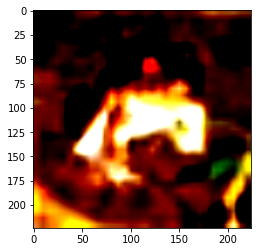

In [29]:
from matplotlib.pyplot import imshow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torchvision.datasets import CIFAR10
import torch.nn as nn
import torch.nn.functional as F 
# from torch.utils.data import Dataset, DataLoader 
import torch.optim as optim
# ResNet model
from torchvision.models import resnet18

# Specifies which GPUs will be used
import os
os.environ["CUDA_DEVICE_ORDER"]='PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"]='0'

custom_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])



train_data = CIFAR10(root='../data', train=True, download=True, transform=custom_transforms)
valid_data = CIFAR10(root='../data', train=False, download=True, transform=custom_transforms)



classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

image, label = train_data[0]
print(classes[label])
imshow(image.permute(1, 2, 0))

In [30]:
train_dataloader = DataLoader(dataset=train_data, batch_size=5, shuffle=True)
valid_dataloader = DataLoader(dataset=valid_data, batch_size=5, shuffle=True)

In [33]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

if torch.cuda.is_available():
    device = torch.device('cuda')

num_epochs = 20

In [ ]:
#train
trained_net, training_history = train_network(
                                    network = model, 
                                    epochs = num_epochs, 
                                    train_dataloader = train_dataloader, 
                                    valid_dataloader = valid_dataloader, 
                                    loss_fn = loss_fn, 
                                    optimizer = optimizer,
                                    save_history = True,
                                    device = device)

In [ ]:
#visualize metrics
loss_train_history = training_history['train_loss']
plt.plot(np.arange(1,len(loss_train_history)+1), loss_train_history, color= 'blue', label = 'Training')
loss_valid_history = training_history['valid_loss']
plt.plot(np.arange(1,len(loss_valid_history)+1), loss_valid_history, color= 'red', label = 'Validation')

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.1)

In [ ]:
loss_train_history = training_history['train_acc']
plt.plot(np.arange(1,len(loss_train_history)+1), loss_train_history, color= 'blue', label = 'Training')
loss_valid_history = training_history['valid_acc']
plt.plot(np.arange(1,len(loss_valid_history)+1), loss_valid_history, color= 'red', label = 'Validation')

plt.xlabel('Epochs')
plt.ylabel('acc')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.1)

In [ ]:
test_loss, test_acc = torch_utils.evaluate(network = resnet18_net, dataloader = valid_dataloader, loss_fn = loss_fn, device = fancy_gpu)
print('test loss = ' + str(round(test_loss,2)) + ', test accuracy = ' + str(round(test_acc,2)))